## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# IMPORTING

Importing all necessary (Classes) for this project.

In [120]:
#IMPORTS
import pandas as pd
import datetime as dt
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn import metrics
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
%matplotlib inline

# DATA

The dataset being analyzed in this project is called "Kickstarter dataset" and was taken from www.Kaggle.com. The main goal for this project is to create a model that can accurately predict if a startup will be successful and to give insights into how to make brand new startups flourish.

Now let's analyze the dataset in order to determine which features can be used as predictors.

In [98]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('18k_Projects.csv',low_memory=False)
df.head()

Id                                               Name  \
0  1007121454  Nail Art and Photos Printed on your Nails w/ E...   
1  2032015036                                         Cold Again   
2   733782855                                 Uchu Bijin Jewelry   
3   514687871  Poetically Speaking: Stories of Love, Triumph ...   
4   683545993  Stranger Travels: Teachings from the Heart of ...   

                                                 Url   State Currency  \
0  https://www.kickstarter.com/projects/137019948...  failed      USD   
1  https://www.kickstarter.com/projects/737783165...  failed      USD   
2  https://www.kickstarter.com/projects/uchubijin...  failed      USD   
3  https://www.kickstarter.com/projects/tylicee/p...  failed      USD   
4  https://www.kickstarter.com/projects/197270300...  failed      USD   

   Top Category    Category           Creator  Location  Updates  Comments  \
0           Art         Art       Dodie Egolf  Puyallup        0         0   
1  Film & Video  Short Film      James Jacobs    Boston        0         0   
2       Fashion     Fashion        Uchu Bijin  New York        1         2   
3    Publishing      Poetry  Tylicee Mysreign   Detroit        0         0   
4    Publishing  Nonfiction      Ian Driscoll  Pucallpa        0         0   

   Rewards   Goal  Pledged  Backers       Start         End  Duration in Days  \
0        9  20000        6        2  2013/12/15  2014/01/14                30   
1        8   3000      180        5  2013/12/15  2014/01/17                33   
2       17   5000     1941       62  2013/12/15  2014/01/14                30   
3        4   5000      130        5  2013/12/15  2014/02/13                60   
4       12  12000     1015       16  2013/12/15  2014/01/14                30   

  Facebook Connected  Facebook Friends  Facebook Shares Has Video   Latitude  \
0                Yes             272.0               70       Yes  47.180395   
1                Yes             573.0               57       Yes  42.332338   
2                 No               NaN              158        No  40.706577   
3                Yes            1285.0                2       Yes  42.354639   
4                Yes             969.0              411       Yes  -8.433810   

    Longitude    Start Timestamp (UTC)      End Timestamp (UTC)  \
0 -122.252903  2013/12/15 01:53:49.000  2014/01/14 01:53:49.000   
1  -71.045620  2013/12/15 02:30:01.000  2014/01/17 02:30:01.000   
2  -73.882374  2013/12/15 01:29:42.000  2014/01/14 01:29:42.000   
3  -83.102840  2013/12/15 01:12:28.000  2014/02/13 01:12:28.000   
4  -74.559570  2013/12/15 01:17:46.000  2014/01/14 01:17:46.000   

                                      Creator Bio  \
0  https://www.kickstarter.com/profile/1370199487   
1   https://www.kickstarter.com/profile/737783165   
2   https://www.kickstarter.com/profile/858150887   
3  https://www.kickstarter.com/profile/1079088465   
4  https://www.kickstarter.com/profile/1972703001   

                                    Creator Website  \
0                                               NaN   
1                                               NaN   
2                              http://uchubijin.com   
3  http://www.linkedin.com/pub/mys-reign/1a/469/4a8   
4              http://strangertravels.wordpress.com   

   Creator - # Projects Created  Creator - # Projects Backed  # Videos  \
0                             1                          0.0       0.0   
1                             1                          4.0       0.0   
2                             2                          2.0       0.0   
3                             1                          2.0       0.0   
4                             1                          0.0       0.0   

   # Images  # Words (Description)  # Words (Risks and Challenges)  # FAQs  
0         2                    297                           153.0       0  
1         0                    276                            98.0       0

Right off the bat, it can be seen that some columns will not make good predictors and some columns will need to be engineered in order to make data useful.

Let's begin by dropping unneeded columns.

In [ ]:
#DROPPING UNNEEDED COLUMNS
unneded_list = ['Id','Name','Url','Creator','Latitude','Longitude',
                'Start Timestamp (UTC)','End Timestamp (UTC)','Creator Bio',
                'Location','Currency']

df = df.drop(columns = unneded_list,axis = 1)

There are still some columns that do not seem too promising, but with some feature engineering, we can extract the most out of them.

In [121]:
#TURNING THE CREATOR WEBSITE COLUMN INTO A A BINARY HAS_CREATOR WEBSITE COLUMN
df['Has_Creator_Website'] = df['Creator Website'].isna()

#DROPPING THE CREATOR WEBSITE COLUMN
df = df.drop(columns='Creator Website',axis=1)

#SINCE THE AMOUNT PLEDGED HAS A DIRECT CORRELATION WITH A STARTUP'S SUCCESS/FAILURE
#A NEW COLUMN NAMED AVERAGE_PLEDGED_PER_BACKER WILL BE CREATED TO SEE IF THE 
#NUMBER OF BACKERS ALSO HAS A DIRECT CORRELATION WITH THE TARGET
df['Average_Pledge_per_Backer'] = df['Pledged']/df['Backers']

#DROPPING PLEDGED AND BACKERS COLUMNS
df = df.drop(columns='Pledged,Backers',axis=1)

#CHANGING START AND END DATES INTO DATETIME FORMATS
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

#EXTRACTING THE MONTHS
df['Start_Month'] = df['Start'].dt.month
df['End_Month'] = df['End'].dt.month

#DROPPING START AND END COLUMNS
df=df.drop(columns = ['Start','End'],axis=1).copy()



KeyError: 'Creator Website'

This is enough feature engineering for now, let's take a deeper look into the remaining features to see if some of them were formated wrong and to see how many null values there are in the dataset.

In [101]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18142 entries, 0 to 18141
Data columns (total 23 columns):
State                             18142 non-null object
Top Category                      18142 non-null object
Category                          18142 non-null object
Updates                           18142 non-null int64
Comments                          18142 non-null int64
Rewards                           18142 non-null int64
Goal                              18142 non-null int64
Start                             18142 non-null object
End                               18142 non-null object
Duration in Days                  18142 non-null int64
Facebook Connected                18142 non-null object
Facebook Friends                  12290 non-null float64
Facebook Shares                   18142 non-null int64
Has Video                         18142 non-null object
Creator - # Projects Created      18142 non-null int64
Creator - # Projects Backed       13898 non-null float64


State  Top Category    Category  Updates  Comments  Rewards   Goal  \
0  failed           Art         Art        0         0        9  20000   
1  failed  Film & Video  Short Film        0         0        8   3000   
2  failed       Fashion     Fashion        1         2       17   5000   
3  failed    Publishing      Poetry        0         0        4   5000   
4  failed    Publishing  Nonfiction        0         0       12  12000   

        Start         End  Duration in Days Facebook Connected  \
0  2013/12/15  2014/01/14                30                Yes   
1  2013/12/15  2014/01/17                33                Yes   
2  2013/12/15  2014/01/14                30                 No   
3  2013/12/15  2014/02/13                60                Yes   
4  2013/12/15  2014/01/14                30                Yes   

   Facebook Friends  Facebook Shares Has Video  Creator - # Projects Created  \
0             272.0               70       Yes                             1   
1             573.0               57       Yes                             1   
2               NaN              158        No                             2   
3            1285.0                2       Yes                             1   
4             969.0              411       Yes                             1   

   Creator - # Projects Backed  # Videos  # Images  # Words (Description)  \
0                          0.0       0.0         2                    297   
1                          4.0       0.0         0                    276   
2                          2.0       0.0        12                   1049   
3                          2.0       0.0         0                    309   
4                          0.0       0.0         6                   1636   

   # Words (Risks and Challenges)  # FAQs  Has_Creator_Website  \
0                           153.0       0                 True   
1                            98.0       0                 True   
2                            66.0       2                False   
3                           169.0       0                False   
4                           216.0       0                False   

   Average_Pledge_per_Backer  
0                   3.000000  
1                  36.000000  
2                  31.306452  
3                  26.000000  
4                  63.437500

The dataset has some issues. There are columns with null values and other's would be more useful if they were bool.

Let's take it step-by-step and begin with columns that we want to be bool.

Columns such as 'Has Video' and 'Facebook Connected' could be more useful if the data in them were binary (0 or 1). 

In [102]:
#CHANGING THE HAS VIDEO COLUMN INTO BINARY
df['Has Video']= df['Has Video'].replace({'Yes':True,'No':False})

#CHANGING THE FACEBOOK CONNECTED COLUMN INTO BINARY
df['Facebook Connected'] = df['Facebook Connected'].replace({'Yes':True,'No':False})

State  Top Category    Category  Updates  Comments  Rewards   Goal  \
0  failed           Art         Art        0         0        9  20000   
1  failed  Film & Video  Short Film        0         0        8   3000   
2  failed       Fashion     Fashion        1         2       17   5000   
3  failed    Publishing      Poetry        0         0        4   5000   
4  failed    Publishing  Nonfiction        0         0       12  12000   

        Start         End  Duration in Days  Facebook Connected  \
0  2013/12/15  2014/01/14                30                True   
1  2013/12/15  2014/01/17                33                True   
2  2013/12/15  2014/01/14                30               False   
3  2013/12/15  2014/02/13                60                True   
4  2013/12/15  2014/01/14                30                True   

   Facebook Friends  Facebook Shares  Has Video  Creator - # Projects Created  \
0             272.0               70       True                             1   
1             573.0               57       True                             1   
2               NaN              158      False                             2   
3            1285.0                2       True                             1   
4             969.0              411       True                             1   

   Creator - # Projects Backed  # Videos  # Images  # Words (Description)  \
0                          0.0       0.0         2                    297   
1                          4.0       0.0         0                    276   
2                          2.0       0.0        12                   1049   
3                          2.0       0.0         0                    309   
4                          0.0       0.0         6                   1636   

   # Words (Risks and Challenges)  # FAQs  Has_Creator_Website  \
0                           153.0       0                 True   
1                            98.0       0                 True   
2                            66.0       2                False   
3                           169.0       0                False   
4                           216.0       0                False   

   Average_Pledge_per_Backer  
0                   3.000000  
1                  36.000000  
2                  31.306452  
3                  26.000000  
4                  63.437500

With that out of the way, we can look at our null values. In order to make a successful model, all null values have to be removed or filled in.

In [ ]:
df.isna().sum()

Facebook Friends feature has a lot of missing values, let's try to figure out why that is

In [ ]:
df.groupby('Facebook Connected').isna()

In [ ]:
df[df['Facebook Connected'] == False]['Facebook Connected','Facebook Friends']

In [ ]:
df.loc[(df['Facebook Connected'] == False),['Facebook Connected','Facebook Friends']]

It appears like all the startups that are not Facebook connected have null values for the number of Facebook friends. Let's confirm if the number of NaN matches the number of startups that are not Facebook Connected.

In [103]:

print(f'Number of Missing in Facebook Friends: {df['Facebook Friends'].isna().sum()},''\n')

print('Is Facebook Connected? \n',df['Facebook Connected'].value_counts())

0


True     12290
False     5852
Name: Facebook Connected, dtype: int64

Since both numbers matches, let's fill all null values in Facebook Friends with 0 because you cannot have Facebook firends if you are not connected to Facebook.

In [ ]:
df['Facebook Friends'].fillna(0,inplace=True)

Let's look at how our data looks after our changes.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18142 entries, 0 to 18141
Data columns (total 23 columns):
State                             18142 non-null object
Top Category                      18142 non-null object
Category                          18142 non-null object
Updates                           18142 non-null int64
Comments                          18142 non-null int64
Rewards                           18142 non-null int64
Goal                              18142 non-null int64
Start                             18142 non-null object
End                               18142 non-null object
Duration in Days                  18142 non-null int64
Facebook Connected                18142 non-null bool
Facebook Friends                  18142 non-null float64
Facebook Shares                   18142 non-null int64
Has Video                         18142 non-null bool
Creator - # Projects Created      18142 non-null int64
Creator - # Projects Backed       13898 non-null float64
# Vi

There are some null values in the '# Videos' columns, so let's drop them all since the number of null rows are so small.

In [105]:
df = df[df['# Videos'].notna()].copy()

State                                0
Top Category                         0
Category                             0
Updates                              0
Comments                             0
Rewards                              0
Goal                                 0
Start                                0
End                                  0
Duration in Days                     0
Facebook Connected                   0
Facebook Friends                     0
Facebook Shares                      0
Has Video                            0
Creator - # Projects Created         0
Creator - # Projects Backed       4244
# Videos                             0
# Images                             0
# Words (Description)                0
# Words (Risks and Challenges)       0
# FAQs                               0
Has_Creator_Website                  0
Average_Pledge_per_Backer            0
dtype: int64

"Creator - # Projects Backed" feature has a lot of missing values as well, but since we will fill out the missing values later, let's make a "Was_missing_#_Projects_Backed" feature just to see if missing that info impacted the model or not.

In [106]:
df['Was_missing_#_Projects_Backed'] = df['Creator - # Projects Backed'].isna()

1.0

Let's take a last look at the dataset info

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18041 entries, 0 to 18141
Data columns (total 24 columns):
State                             18041 non-null object
Top Category                      18041 non-null object
Category                          18041 non-null object
Updates                           18041 non-null int64
Comments                          18041 non-null int64
Rewards                           18041 non-null int64
Goal                              18041 non-null int64
Duration in Days                  18041 non-null int64
Facebook Connected                18041 non-null bool
Facebook Friends                  18041 non-null float64
Facebook Shares                   18041 non-null int64
Has Video                         18041 non-null bool
Creator - # Projects Created      18041 non-null int64
Creator - # Projects Backed       13797 non-null float64
# Videos                          18041 non-null float64
# Images                          18041 non-null int64
# Wo

Everything looks good, so let's move into modeling.

# Baseline Model (Random Forrest)

In [110]:
y = df['State']
X = df.drop(columns = 'State',axis = 1).copy()
X = pd.get_dummies(X)


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 69)


imputer = SimpleImputer(strategy='mean')


X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

y_test.value_counts(normalize=True)

failed        0.510391
successful    0.489609
Name: State, dtype: float64

In [111]:
df_Scrap = pd.DataFrame(X_train,columns = X.columns)
df_Scrap

Updates  Comments  Rewards     Goal  Duration in Days  \
0          0.0       9.0     12.0  10000.0              30.0   
1          7.0       0.0      4.0   4000.0              30.0   
2          1.0       0.0     12.0  10000.0              60.0   
3          0.0       0.0     11.0  15000.0              30.0   
4          4.0      11.0      5.0   1313.0              28.0   
...        ...       ...      ...      ...               ...   
14427      0.0       0.0     12.0   3450.0              59.0   
14428      3.0       0.0      5.0   1000.0              30.0   
14429      3.0       0.0      8.0   3333.0              45.0   
14430      0.0       2.0      3.0   2750.0              31.0   
14431      4.0     198.0     16.0  20000.0              30.0   

       Facebook Connected  Facebook Friends  Facebook Shares  Has Video  \
0                     1.0             229.0             23.0        1.0   
1                     1.0             127.0             28.0        1.0   
2                     0.0               0.0             14.0        1.0   
3                     1.0             126.0              0.0        0.0   
4                     1.0             236.0            210.0        1.0   
...                   ...               ...              ...        ...   
14427                 1.0             671.0             34.0        1.0   
14428                 0.0               0.0            269.0        1.0   
14429                 0.0               0.0            509.0        1.0   
14430                 1.0            1070.0             94.0        1.0   
14431                 1.0            1821.0           3423.0        1.0   

       Creator - # Projects Created  Creator - # Projects Backed  # Videos  \
0                               1.0                     0.000000       0.0   
1                               2.0                     5.112746       0.0   
2                               2.0                     1.000000       0.0   
3                               1.0                     5.112746       0.0   
4                               1.0                    17.000000       0.0   
...                             ...                          ...       ...   
14427                           1.0                     1.000000       0.0   
14428                           1.0                     2.000000       0.0   
14429                           1.0                     5.112746       0.0   
14430                           1.0                     5.112746       0.0   
14431                           1.0                     7.000000       3.0   

       # Images  # Words (Description)  # Words (Risks and Challenges)  \
0           5.0                  303.0                            83.0   
1           5.0                  398.0                            82.0   
2          11.0                 1864.0                           128.0   
3           3.0                  482.0                           140.0   
4           2.0                 1314.0                            96.0   
...         ...                    ...                             ...   
14427       0.0                  260.0                            94.0   
14428       4.0                  339.0                           296.0   
14429       6.0                 1286.0                           101.0   
14430       0.0                  361.0                            71.0   
14431       4.0                 1068.0                           340.0   

       # FAQs  Has_Creator_Website  Average_Pledge_per_Backer  \
0         0.0                  0.0                  59.727273   
1         0.0                  1.0                  59.176471   
2         0.0                  1.0                 165.863636   
3         0.0                  0.0                  18.000000   
4         0.0                  0.0                  26.296296   
...       ...                  ...                        ...   
14427     0.0                  0.0                  21.0

# Model Improvement (Vanilla XGBoost)

In [112]:
clf = xgb.XGBClassifier()
clf.fit(scaled_X_train, y_train)
training_preds = clf.predict(scaled_X_train)
val_preds = clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 90.67%
Validation accuracy: 89.64%


# Tuning XGBoost Model

In [113]:
param_grid = {
    "learning_rate": [0.1,0.05,.01],
    'max_depth': [3,6,9,12,24],
    'min_child_weight': [1,3,5,10],
    'subsample': [1,0.6,0.7],
    'n_estimators': [100,250],
}

In [114]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=3)
grid_clf.fit(scaled_X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(scaled_X_train)
val_preds = grid_clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 3
n_estimators: 250
subsample: 0.7

Training Accuracy: 92.11%
Validation accuracy: 90.33%


In [115]:
df_import = pd.DataFrame(clf.feature_importances_, index = X.columns,columns = ['Value'])
df_import[df_import['Value']!=0].sort_values('Value',ascending=False,)

Value
Updates                         0.190143
Facebook Shares                 0.184774
Goal                            0.086781
Average_Pledge_per_Backer       0.073579
Comments                        0.063270
End_Month                       0.038590
Duration in Days                0.029974
Category_Video Games            0.028683
Was_missing_#_Projects_Backed   0.023711
Top Category_Music              0.022496
Has Video                       0.020544
Facebook Friends                0.019961
Top Category_Fashion            0.018718
Top Category_Theater            0.018524
Creator - # Projects Backed     0.018469
Category_Short Film             0.017633
Category_Product Design         0.017083
Creator - # Projects Created    0.015927
Top Category_Film & Video       0.015396
Category_Dance                  0.014877
# Words (Description)           0.012206
Start_Month                     0.010151
Top Category_Games              0.009649
Rewards                         0.008090
# Videos                        0.007745
Top Category_Technology         0.006400
# Images                        0.006125
Top Category_Photography        0.005941
# FAQs                          0.005423
Category_Narrative Film         0.005164
# Words (Risks and Challenges)  0.003973

In [116]:
# df_import = df_import.reset_index
display(df_import)

Value
Updates               0.190143
Comments              0.063270
Rewards               0.008090
Goal                  0.086781
Duration in Days      0.029974
...                        ...
Category_Webseries    0.000000
Category_Workshops    0.000000
Category_World Music  0.000000
Category_Young Adult  0.000000
Category_Zines        0.000000

[181 rows x 1 columns]

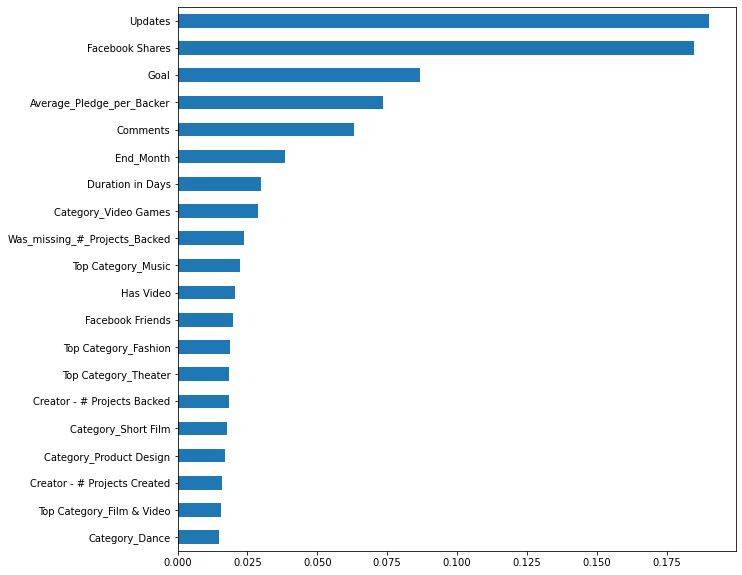

In [117]:
def plot_importance(tree, top_n=20,figsize=(10,10)):
    df_importance = pd.Series(tree.feature_importances_,index=X.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize)
    return df_importance
plot_importance(clf);

In [118]:
def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report #fig,axes

------------------------------------------------------------
[i] CLASSIFICATION REPORT STARTUP XGBOOST
------------------------------------------------------------
              precision    recall  f1-score   support

      failed       0.93      0.87      0.90      1842
  successful       0.88      0.93      0.90      1767

    accuracy                           0.90      3609
   macro avg       0.90      0.90      0.90      3609
weighted avg       0.91      0.90      0.90      3609

------------------------------------------------------------




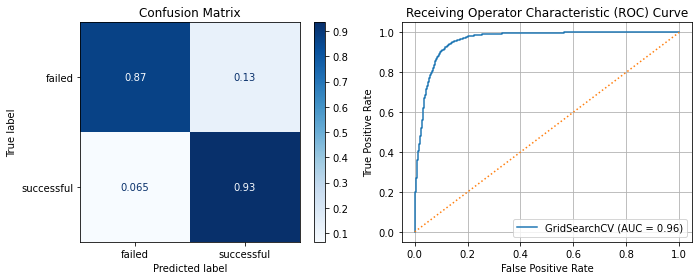

{'failed': {'precision': 0.9332559489262914,
  'recall': 0.8729641693811075,
  'f1-score': 0.9021037868162693,
  'support': 1842},
 'successful': {'precision': 0.8759278897136797,
  'recall': 0.9349179400113187,
  'f1-score': 0.9044620859567479,
  'support': 1767},
 'accuracy': 0.9032973122748684,
 'macro avg': {'precision': 0.9045919193199856,
  'recall': 0.9039410546962131,
  'f1-score': 0.9032829363865087,
  'support': 3609},
 'weighted avg': {'precision': 0.9051875974082296,
  'recall': 0.9032973122748684,
  'f1-score': 0.9032584320313499,
  'support': 3609}}

In [119]:
evaluate_classification(grid_clf,scaled_X_test,y_test,label='STARTUP XGBOOST')